#### Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/dataset")
!ls

channels  final_keywords.txt  monetization_labels.json	videos


In [ ]:
import csv
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict

In [ ]:
stem_videos = pd.read_csv('videos/videos_stem.csv')

In [ ]:
stem_categories = pd.read_csv('videos/stem_videos_with_matched_category.csv')

In [ ]:
stem_videos['stem_category'] = stem_categories['matched_category']

In [ ]:
channels = pd.read_csv('channels/education_channel_with_country.csv')

In [ ]:
timeseries = pd.read_csv("channels/df_timeseries_en.tsv.gz",sep="\t")

In [ ]:
timeseries = timeseries[timeseries['category'] == 'Education']

In [ ]:
timeseries.rename(columns={"channel": "channel_id"}, inplace=True)
channels.rename(columns={"channel": "channel_id"}, inplace=True)

channels_of_interest = stem_videos["channel_id"].unique()
filtered_timeseries = timeseries[timeseries["channel_id"].isin(channels_of_interest)]

<ipython-input-12-2b0f0d9f71df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries.rename(columns={"channel": "channel_id"}, inplace=True)


In [ ]:
channel_info = channels[["channel_id", "join_date", "name_cc", "country"]].drop_duplicates()
merged_data = filtered_timeseries.merge(channel_info, on="channel_id", how="inner")

### What stragegies did Indian STEM content creator used? Did they produce videos regularly?

In [ ]:
# channels producing at leastt one stem videos
channels_of_interest = channels[channels['channel_id'].isin(channels_of_interest)]

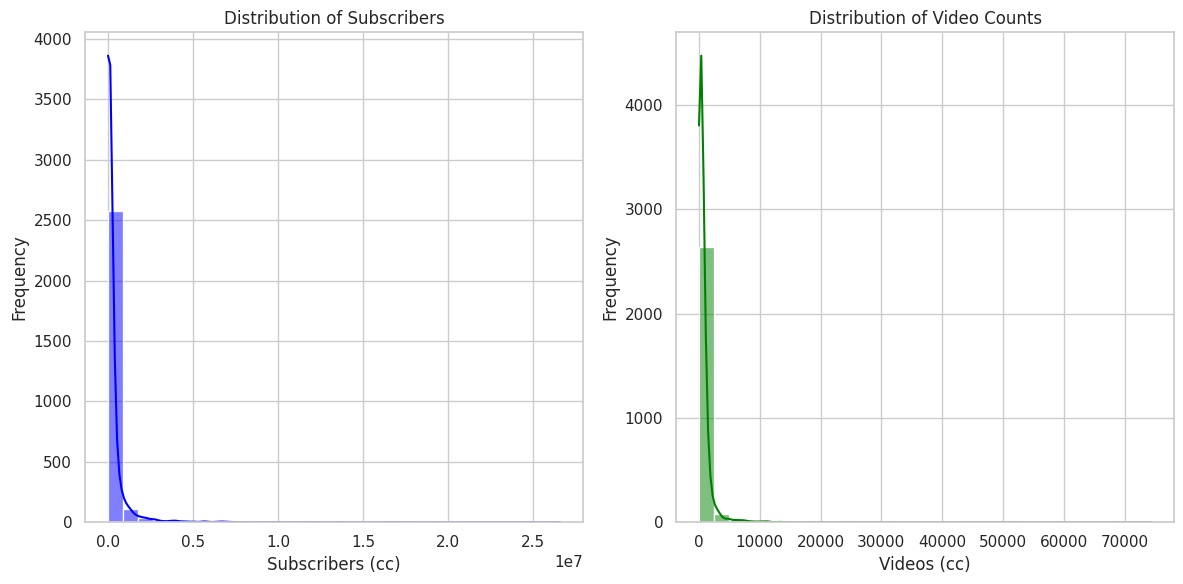

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create a figure with two subplots for subscribers and video counts
plt.figure(figsize=(12, 6))

# Subscribers distribution
plt.subplot(1, 2, 1)
sns.histplot(channels_of_interest['subscribers_cc'], kde=True, bins=30, color="blue")
plt.title("Distribution of Subscribers")
plt.xlabel("Subscribers (cc)")
plt.ylabel("Frequency")

# Videos count distribution
plt.subplot(1, 2, 2)
sns.histplot(channels_of_interest['videos_cc'], kde=True, bins=30, color="green")
plt.title("Distribution of Video Counts")
plt.xlabel("Videos (cc)")
plt.ylabel("Frequency")

# Show the plots
plt.tight_layout()
plt.show()

<ipython-input-16-aa045cb2867a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channels_of_interest['log10_subscribers_cc'] = channels_of_interest['subscribers_cc'].apply(lambda x: np.log10(1 + x))
<ipython-input-16-aa045cb2867a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channels_of_interest['log10_videos_cc'] = channels_of_interest['videos_cc'].apply(lambda x: np.log10(1 + x))


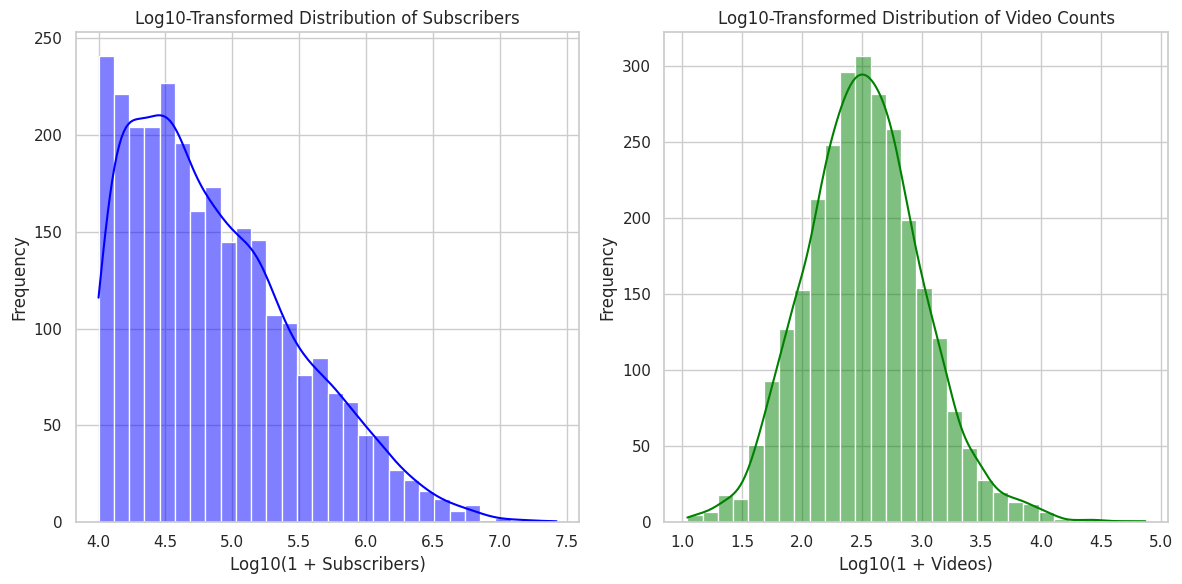

In [ ]:
# Apply base-10 log transformation to the columns
channels_of_interest['log10_subscribers_cc'] = channels_of_interest['subscribers_cc'].apply(lambda x: np.log10(1 + x))
channels_of_interest['log10_videos_cc'] = channels_of_interest['videos_cc'].apply(lambda x: np.log10(1 + x))

# Plot base-10 log-transformed distributions
plt.figure(figsize=(12, 6))

# Log10 Subscribers distribution
plt.subplot(1, 2, 1)
sns.histplot(channels_of_interest['log10_subscribers_cc'], kde=True, bins=30, color="blue")
plt.title("Log10-Transformed Distribution of Subscribers")
plt.xlabel("Log10(1 + Subscribers)")
plt.ylabel("Frequency")

# Log10 Videos count distribution
plt.subplot(1, 2, 2)
sns.histplot(channels_of_interest['log10_videos_cc'], kde=True, bins=30, color="green")
plt.title("Log10-Transformed Distribution of Video Counts")
plt.xlabel("Log10(1 + Videos)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**We can define regularity as the consistency in video uploads. Channels that upload videos at more consistent intervals (e.g., weekly or daily) can be considered more regular.**

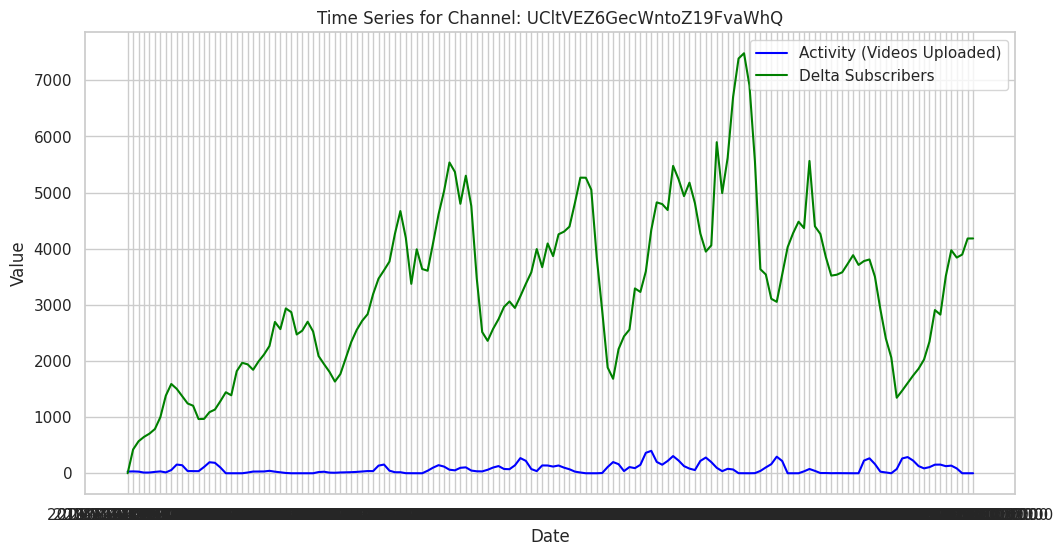

In [ ]:
import matplotlib.pyplot as plt

# Select a single channel for visualization
channel_id = "UCltVEZ6GecWntoZ19FvaWhQ"
channel_data = merged_data[merged_data["channel_id"] == channel_id]

# Plot activity vs delta_subs over time
plt.figure(figsize=(12, 6))
plt.plot(channel_data["datetime"], channel_data["activity"], label="Activity (Videos Uploaded)", color="blue")
plt.plot(channel_data["datetime"], channel_data["delta_subs"], label="Delta Subscribers", color="green")
plt.title(f"Time Series for Channel: {channel_id}")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Based on amount of uploads.. give them activity level every week

In [ ]:
import pandas as pd
import numpy as np

# Classify activity levels
def classify_activity(activity):
    if activity == 0:
        return "Inactive"
    elif activity <= 5:
        return "Low"
    elif activity <= 15:
        return "Medium"
    else:
        return "High"

merged_data['activity_level'] = merged_data['activity'].apply(classify_activity)
# Calculate subscriber growth rate
merged_data['growth_rate'] = (merged_data['delta_subs'] / merged_data['subs']) * 100
merged_data['growth_rate'] = merged_data['growth_rate'].fillna(0)  # Handle NaN values

# Extract year, month, week, and day of week
merged_data['date'] = pd.to_datetime(merged_data['datetime'])
merged_data['year'] = merged_data['date'].dt.year
merged_data['month'] = merged_data['date'].dt.month
merged_data['week'] = merged_data['date'].dt.isocalendar().week
merged_data['day'] = merged_data['date'].dt.dayofweek  # Monday = 0, Sunday = 6

# Adjust the pivot table for new heatmap format
heatmap_data = merged_data.pivot_table(
    index='year',       # Rows as years
    columns='week',     # Columns as weeks (1 to 52)
    values='delta_videos',  # Values as growth rates
    aggfunc='mean'      # Aggregate by mean growth rate
)

# Replace missing values with 0
heatmap_data = heatmap_data.fillna(0)


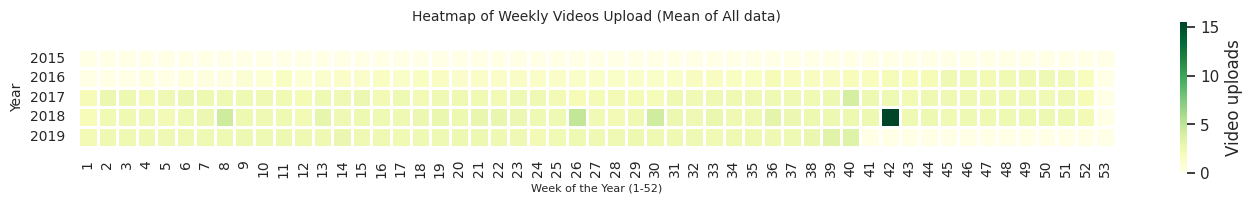

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(14, 2))
sns.heatmap(
    heatmap_data,
    cmap="YlGn",  # Use a perceptually uniform color palette
    #cbar_kws={'label': 'Subscriber Growth Rate (%)'},
    cbar_kws={'label': 'Video uploads'},
    linewidths=2,  # Add thin grid lines between cells
    linecolor="white",  # Set grid line color
    square = True,
    annot=False,  # Change to True to annotate cells
    fmt=".1f"  # Format annotations with 1 decimal place
)

# Customize plot
plt.title("Heatmap of Weekly Videos Upload (Mean of All data)", fontsize=10, pad=20)
plt.xlabel("Week of the Year (1-52)", fontsize=8)
plt.ylabel("Year", fontsize=10)
plt.xticks(fontsize=10, rotation = 90)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()

# Show plot
plt.show()

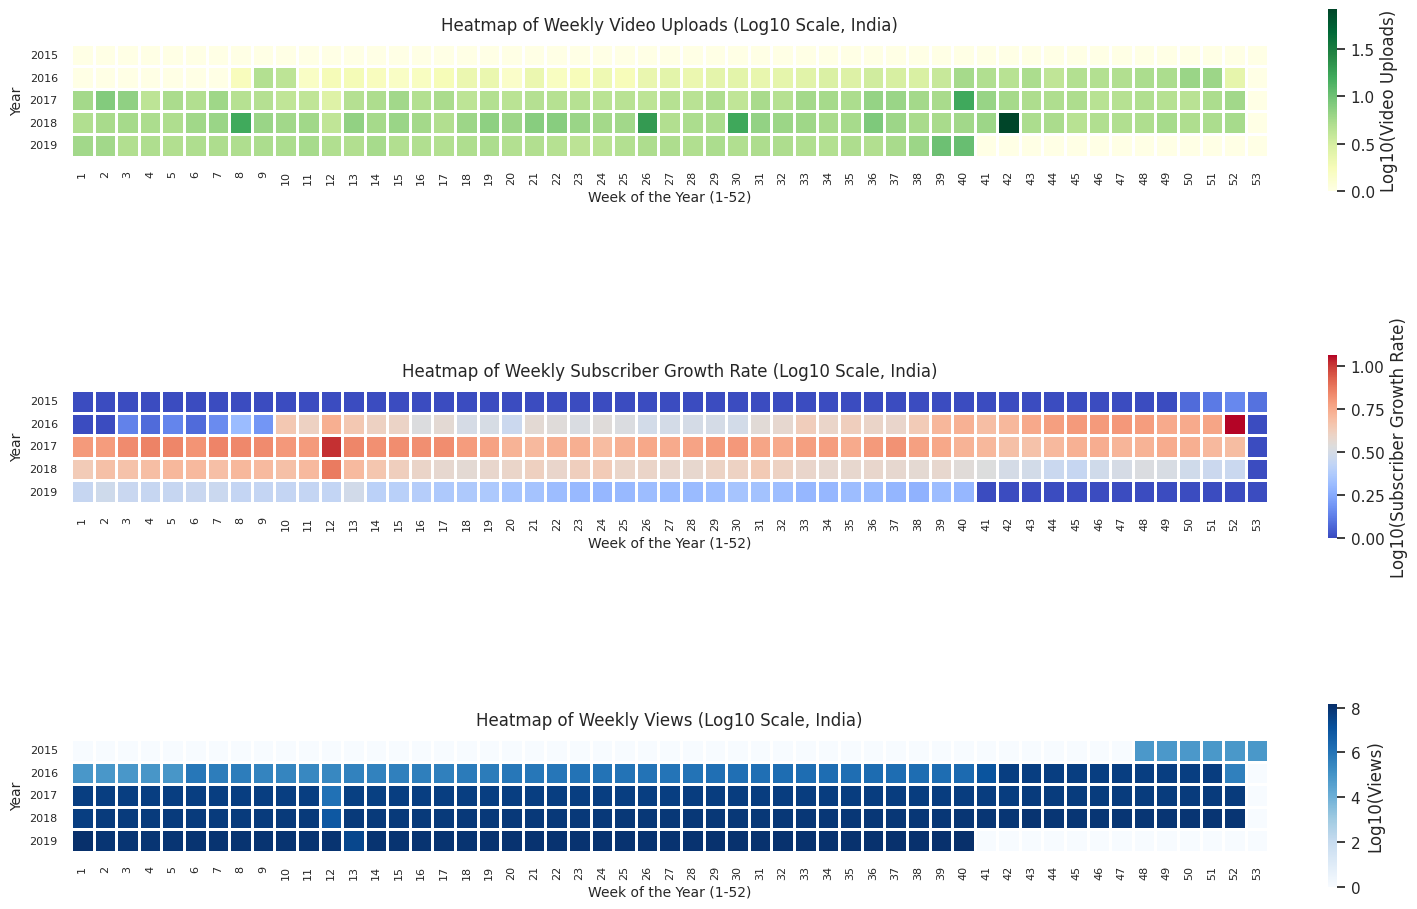

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter data for Indian channels
indian_data = merged_data[merged_data['country'] == 'IN']

# Create pivot tables for Indian data
heatmap_videos = indian_data.pivot_table(
    index='year', columns='week', values='delta_videos', aggfunc='mean').fillna(0)
heatmap_growth = indian_data.pivot_table(
    index='year', columns='week', values='growth_rate', aggfunc='mean').fillna(0)
heatmap_views = indian_data.pivot_table(
    index='year', columns='week', values='views', aggfunc='mean').fillna(0)

# Apply log10 transformation (add small constant to avoid log(0))
heatmap_videos = np.log10(heatmap_videos + 1)
heatmap_growth = np.log10(heatmap_growth + 1)
heatmap_views = np.log10(heatmap_views + 1)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 9), constrained_layout=True, gridspec_kw={'hspace': 0.5})

# Plot the top heatmap (Video Uploads)
sns.heatmap(
    heatmap_videos,
    ax=axes[0],
    cmap="YlGn",
    cbar_kws={'label': 'Log10(Video Uploads)'},
    linewidths=2,
    linecolor="white",
    square=True,
    annot=False
)
axes[0].set_title("Heatmap of Weekly Video Uploads (Log10 Scale, India)", fontsize=12, pad=10)
axes[0].set_xlabel("Week of the Year (1-52)", fontsize=10)
axes[0].set_ylabel("Year", fontsize=10)
axes[0].tick_params(axis='x', labelrotation=90, labelsize=8)
axes[0].tick_params(axis='y', labelsize=8)

# Plot the middle heatmap (Growth Rate)
sns.heatmap(
    heatmap_growth,
    ax=axes[1],
    cmap="coolwarm",
    cbar_kws={'label': 'Log10(Subscriber Growth Rate)'},
    linewidths=2,
    linecolor="white",
    square=True,
    annot=False
)
axes[1].set_title("Heatmap of Weekly Subscriber Growth Rate (Log10 Scale, India)", fontsize=12, pad=10)
axes[1].set_xlabel("Week of the Year (1-52)", fontsize=10)
axes[1].set_ylabel("Year", fontsize=10)
axes[1].tick_params(axis='x', labelrotation=90, labelsize=8)
axes[1].tick_params(axis='y', labelsize=8)

# Plot the bottom heatmap (Views)
sns.heatmap(
    heatmap_views,
    ax=axes[2],
    cmap="Blues",
    cbar_kws={'label': 'Log10(Views)'},
    linewidths=2,
    linecolor="white",
    square=True,
    annot=False
)
axes[2].set_title("Heatmap of Weekly Views (Log10 Scale, India)", fontsize=12, pad=10)
axes[2].set_xlabel("Week of the Year (1-52)", fontsize=10)
axes[2].set_ylabel("Year", fontsize=10)
axes[2].tick_params(axis='x', labelrotation=90, labelsize=8)
axes[2].tick_params(axis='y', labelsize=8)

# Show the plot
plt.show()

### More views/uploads/subscribers growth in exam seasons? Less in vacation season?

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Define seasons
def categorize_season(month):
    if month in [12, 1, 5, 6]:  # Exam season
        return "Exam"
    elif month in [7, 8]:  # Vacation
        return "Vacation"
    else:  # Other months
        return "Other"

# Add season category to the data
merged_data['month'] = pd.to_datetime(merged_data['datetime']).dt.month
merged_data['season'] = merged_data['month'].apply(categorize_season)

# Group by season and calculate statistics
season_stats = merged_data.groupby('season')['views'].agg(['mean', 'median', 'count']).reset_index()
print(season_stats)

# Perform ANOVA to test for differences in views across seasons
views_exam = merged_data[merged_data['season'] == "Exam"]['views']
views_vacation = merged_data[merged_data['season'] == "Vacation"]['views']
views_other = merged_data[merged_data['season'] == "Other"]['views']
f_stat, p_value = f_oneway(views_exam, views_vacation, views_other)
print(f"ANOVA F-Statistic: {f_stat}, P-Value: {p_value}")


     season          mean        median   count
0      Exam  3.652244e+07  3.549169e+06  124137
1     Other  3.681118e+07  3.600682e+06  184059
2  Vacation  3.810889e+07  3.747408e+06   73380
ANOVA F-Statistic: 0.5788189130112593, P-Value: 0.5605605381935264


If we take all channels into accounts, then we will get non-significant result. However, we can run the test for every channel, and we can see what channels have significant higher views during exam seasons

In [99]:
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# Define Exam Season
def is_exam_season(month):
    return month in [11,12,5,6]

# Add 'is_exam_season' column
merged_data['month'] = pd.to_datetime(merged_data['datetime']).dt.month
merged_data['is_exam_season'] = merged_data['month'].apply(is_exam_season)

# Group by channel and perform t-test for each channel
results = []

for channel_id, group in merged_data.groupby('channel_id'):
    views_exam = group[group['is_exam_season']]['views']
    views_non_exam = group[~group['is_exam_season']]['views']

    # Perform t-test if there is enough data
    if len(views_exam) > 1 and len(views_non_exam) > 1:
        t_stat, p_value = ttest_ind(views_exam, views_non_exam, equal_var=False)  # Welch's t-test
        results.append({
            'channel_id': channel_id,
            'mean_exam_views': views_exam.mean(),
            'mean_non_exam_views': views_non_exam.mean(),
            't_stat': t_stat,
            'p_value': p_value
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Filter channels with significant differences
significant_channels = results_df[results_df['p_value'] < 0.05]

In [100]:
# Extract unique channel information from merged_data
channel_info = merged_data[['channel_id', 'name_cc','country']].drop_duplicates()

# Merge significant_channels with channel_info
significant_channels_with_info = pd.merge(
    significant_channels,
    channel_info,
    on='channel_id',
    how='left'
)

In [101]:
significant_channels_with_info[significant_channels_with_info['country'] == 'IN']

,channel_id,mean_exam_views,mean_non_exam_views,t_stat,p_value,name_cc,country
0,UC-6XySAR_z9CsE2vC2epkNw,5.996548e+05,7.420463e+05,-5.630691,0.000012,ABHISHEK Tutorial,IN
2,UC-lUDsUcjn1H1zU8y6gdtRQ,2.491136e+06,3.157439e+06,-2.539715,0.017234,Enoma,IN
4,UC3B_49dKW4SGTiapl1G6yuA,1.880780e+07,1.451110e+07,2.245619,0.030196,DWIJENCY,IN
5,UC3LeOpWTLFDIYz4_sgAGgkQ,1.189248e+06,1.324637e+06,-2.836083,0.006414,Positive Revolution,IN
10,UC94gTWORLJu9rjpTrZ-JOvw,4.017907e+06,3.852055e+06,1.994122,0.049826,Toppers Only,IN
14,UCGG4fJHkjBDkb_9NKgAgo3g,3.853800e+05,5.233965e+05,-6.043664,0.000046,Tops Study,IN
22,UCVOmVq2QgQHmbQi25slj4wQ,1.585454e+06,2.285007e+06,-2.452698,0.021395,Dashamlav,IN
28,UC_QCGneCW7kEwdjawFSDkCw,1.859777e+06,2.390690e+06,-3.448441,0.001361,Pratyaya EduResearch...,IN
32,UCfrRUp2ERVNICHAY17cL5Ug,1.068397e+05,3.045561e+06,-3.229370,0.002999,fitmanjeet,IN
36,UCjBWD_W_zlF5cLO4l5fW6Ww,3.592110e+06,4.616193e+06,-2.842114,0.006788,Dr Neha Joshi Care C...,IN


In [102]:
# Define exam season
window_size = 3  # For moving average

def is_exam_season(month):
    return month in [11, 12, 5, 6]

# Add 'is_exam_season' column to the merged_data
merged_data['month'] = pd.to_datetime(merged_data['datetime']).dt.month
merged_data['is_exam_season'] = merged_data['month'].apply(is_exam_season)

# Filter data for significant Indian channels
significant_channel_ids = significant_channels_with_info['channel_id'].unique()
significant_channel_data = merged_data[merged_data['channel_id'].isin(significant_channel_ids)]

# Ensure datetime is in the correct format
significant_channel_data['datetime'] = pd.to_datetime(significant_channel_data['datetime'])

# Aggregate delta views and delta videos by date and exam season
aggregated_data = significant_channel_data.groupby(['datetime', 'is_exam_season'])[['delta_views', 'delta_videos']].sum().reset_index()
aggregated_data['datetime'] = aggregated_data['datetime'].dt.date
aggregated_data['smoothed_delta_views'] = aggregated_data['delta_views'].rolling(window=window_size, min_periods=1).mean()
aggregated_data['smoothed_delta_videos'] = aggregated_data['delta_videos'].rolling(window=window_size, min_periods=1).mean()


<ipython-input-102-b60cb26154c8>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



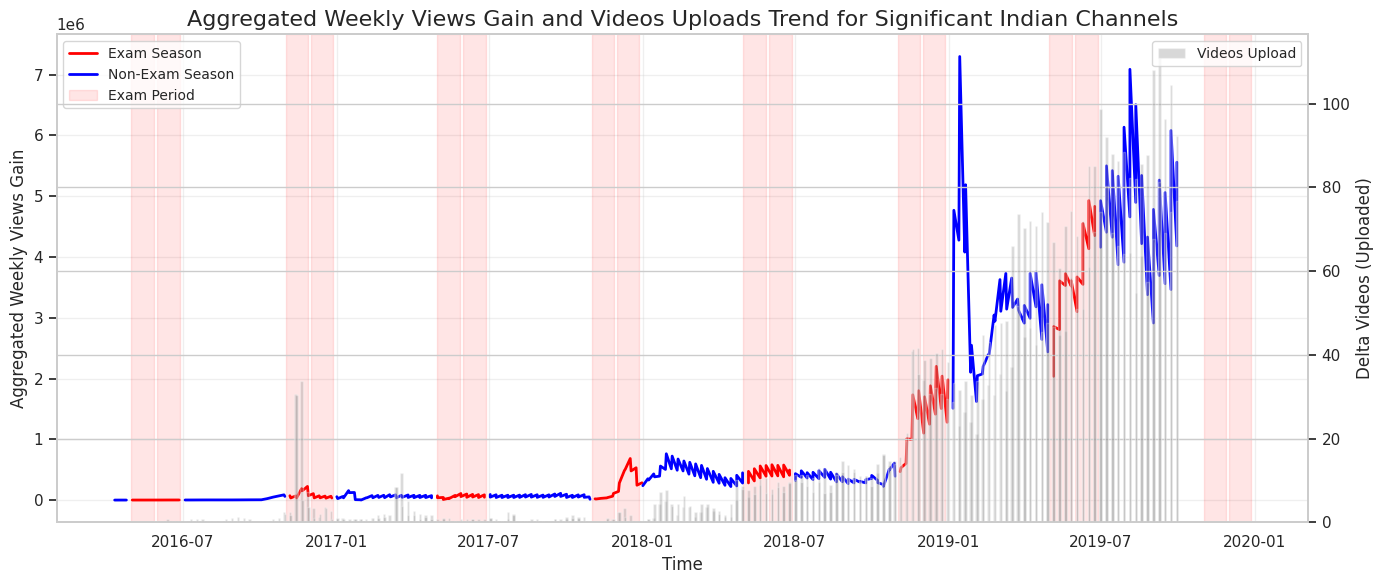

In [106]:
# Split the data into exam and non-exam periods
exam_data = aggregated_data[aggregated_data['is_exam_season']]
non_exam_data = aggregated_data[~aggregated_data['is_exam_season']]

# Plot the figure with dual Y-axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Line chart for delta_views
for _, group in exam_data.groupby((exam_data['datetime'].diff() > pd.Timedelta(days=7)).cumsum()):
    ax1.plot(group['datetime'], group['smoothed_delta_views'], color='red', label='Exam Season' if 'Exam Season' not in ax1.get_legend_handles_labels()[1] else "", linewidth=2)

for _, group in non_exam_data.groupby((non_exam_data['datetime'].diff() > pd.Timedelta(days=7)).cumsum()):
    ax1.plot(group['datetime'], group['smoothed_delta_views'], color='blue', label='Non-Exam Season' if 'Non-Exam Season' not in ax1.get_legend_handles_labels()[1] else "", linewidth=2)

# Add shaded exam periods
for i, year in enumerate(significant_channel_data['datetime'].dt.year.unique()):
    for month in [11, 12, 5, 6]:
        ax1.axvspan(
            pd.Timestamp(f"{year}-{month}-01"),
            pd.Timestamp(f"{year}-{month}-28"),
            color='red', alpha=0.1,
            label='Exam Period' if i == 0 and month == 11 else ""
        )

# Secondary Y-axis for delta_videos as bar chart
ax2 = ax1.twinx()
ax2.bar(aggregated_data['datetime'], aggregated_data['smoothed_delta_videos'], color='gray', alpha=0.3, label='Videos Upload', width=3)

# Customize primary Y-axis (delta_views)
ax1.set_ylabel("Aggregated Weekly Views Gain", fontsize=12)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_title("Aggregated Weekly Views Gain and Videos Uploads Trend for Significant Indian Channels", fontsize=16)
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(alpha=0.3)

# Customize secondary Y-axis (delta_videos)
ax2.set_ylabel("Delta Videos (Uploaded)", fontsize=12)
ax2.legend(loc="upper right", fontsize=10)

# Tight layout
plt.tight_layout()
plt.show()

We can noticeable increases in delta views, particularly in exam seasons. This suggests that students are more likely to engage with these channels during exams, potentially seeking educational content for preparation.

Over the years, there’s a gradual increase in baseline delta views across both exam and non-exam periods. This could indicate the growing popularity of these educational channels.

<ipython-input-104-70d0a148e53e>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




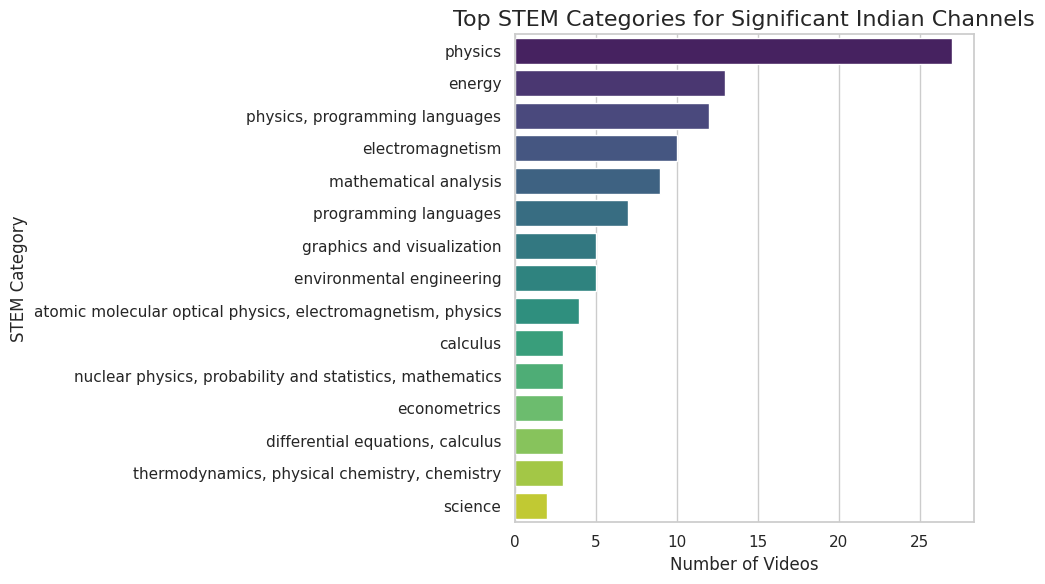

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split stem_category into lists
# Filter stem_videos for significant Indian channels
significant_indian_channels = significant_channels_with_info[significant_channels_with_info['country'] == 'IN']
significant_channel_ids = significant_indian_channels['channel_id'].unique()

# Filter stem_videos
significant_videos = stem_videos[stem_videos['channel_id'].isin(significant_channel_ids)]

# Step 2: Explode the lists into individual rows
exploded_categories = significant_videos.explode('stem_category')

# Step 3: Remove extra whitespace and normalize categories
exploded_categories['stem_category'] = exploded_categories['stem_category'].str.strip()

# Step 4: Count occurrences of each category
category_counts = exploded_categories['stem_category'].value_counts().reset_index()
category_counts.columns = ['stem_category', 'count']

# Step 5: Visualize the distribution
plt.figure(figsize=(10, 6))
sns.barplot(data=category_counts.head(15), x='count', y='stem_category', palette='viridis')  # Show top 15 categories
plt.title("Top STEM Categories for Significant Indian Channels", fontsize=16)
plt.xlabel("Number of Videos", fontsize=12)
plt.ylabel("STEM Category", fontsize=12)
plt.tight_layout()
plt.show()

### What is the correlation between delta activity(recent uploads in 15 days) and delta views? (general worldwide)

In [ ]:
# Group by channel_id and calculate correlations
def compute_correlation(group):
    return pd.Series({
        "corr_activity_delta_subs": group["activity"].corr(group["delta_subs"]),
        "corr_activity_delta_views": group["activity"].corr(group["delta_views"]),
    })

correlations = merged_data.groupby("channel_id").apply(compute_correlation).reset_index()

# Check the results
print(correlations.head())

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


                 channel_id  corr_activity_delta_subs  \
0  UC-0d3muMfcERwnqn7CEIW-A                 -0.091601   
1  UC-6XySAR_z9CsE2vC2epkNw                  0.123811   
2  UC-73P87iZAfZ05it7mjgbLg                  0.719613   
3  UC-75_Zh-CLF7hN8dM4EGEGA                 -0.116572   
4  UC-7DK1Fr7M8UzPBVHFULk2A                  0.133884   

   corr_activity_delta_views  
0                  -0.080215  
1                   0.185027  
2                   0.700177  
3                  -0.054825  
4                   0.162312  


<ipython-input-37-c82a46e1458a>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = merged_data.groupby("channel_id").apply(compute_correlation).reset_index()


In [92]:
from scipy.stats import t
import numpy as np

# Function to compute correlation and 95% CI
def compute_ci(data, column):
    mean = data[column].mean()
    std = data[column].std()
    n = len(data)
    ci = t.ppf(0.975, df=n-1) * (std / np.sqrt(n))  # 95% CI
    return mean, mean - ci, mean + ci

# Group by channel_id and calculate correlations for both activity and delta_videos
def compute_correlation(group):
    return pd.Series({
        "corr_activity_delta_views": group["activity"].corr(group["delta_views"]),
        "corr_activity_delta_subs": group["activity"].corr(group["delta_subs"]),
        "corr_delta_videos_delta_views": group["delta_videos"].corr(group["delta_views"]),
        "corr_delta_videos_delta_subs": group["delta_videos"].corr(group["delta_subs"]),
    })

correlations = merged_data.groupby("channel_id").apply(compute_correlation).reset_index()

# Compute 95% CI for each type of correlation
correlation_columns = ["corr_activity_delta_views", "corr_activity_delta_subs",
                       "corr_delta_videos_delta_views", "corr_delta_videos_delta_subs"]

ci_results = {}
for column in correlation_columns:
    mean, lower_ci, upper_ci = compute_ci(correlations, column)
    ci_results[column] = {"mean": mean, "lower_ci": lower_ci, "upper_ci": upper_ci}

# Convert CI results to a DataFrame for reference
ci_df = pd.DataFrame(ci_results).T.reset_index()
ci_df.columns = ["Correlation Type", "Mean", "Lower CI", "Upper CI"]
print(ci_df)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



                Correlation Type      Mean  Lower CI  Upper CI
0      corr_activity_delta_views  0.144888  0.133711  0.156065
1       corr_activity_delta_subs  0.101150  0.090416  0.111884
2  corr_delta_videos_delta_views  0.138400  0.128815  0.147985
3   corr_delta_videos_delta_subs  0.098699  0.089417  0.107982


<ipython-input-92-c3054788603d>:21: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<ipython-input-97-51d1d373e8ac>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




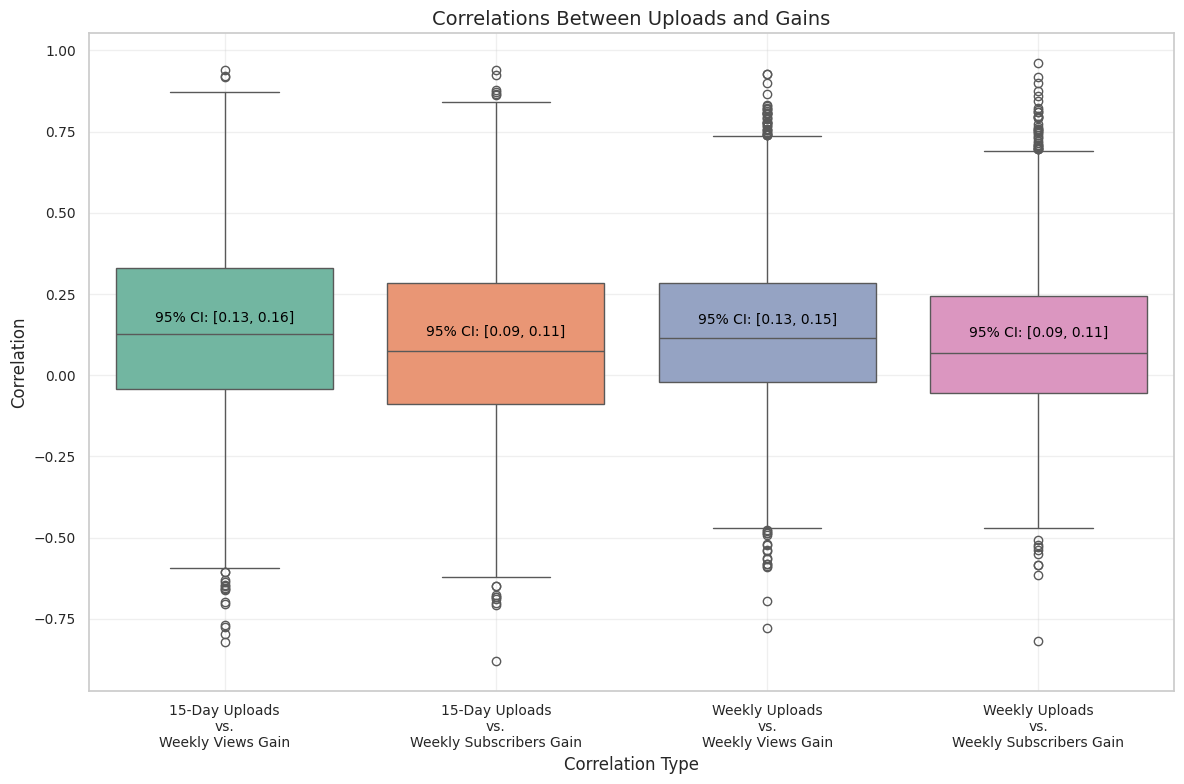

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt correlations for boxplot
correlation_melted = correlations.melt(id_vars=["channel_id"],
                                       value_vars=correlation_columns,
                                       var_name="Correlation Type", value_name="Correlation")

# 更新的變數名稱映射，添加換行符號
x_label_mapping = {
    "corr_activity_delta_views": "15-Day Uploads\nvs.\nWeekly Views Gain",
    "corr_activity_delta_subs": "15-Day Uploads\nvs.\nWeekly Subscribers Gain",
    "corr_delta_videos_delta_views": "Weekly Uploads\nvs.\nWeekly Views Gain",
    "corr_delta_videos_delta_subs": "Weekly Uploads\nvs.\nWeekly Subscribers Gain"
}

# 替換變數名稱為更清晰的標籤
correlation_melted["Correlation Type"] = correlation_melted["Correlation Type"].map(x_label_mapping)

# 繪製更新後的 boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x="Correlation Type", y="Correlation", data=correlation_melted, palette="Set2")

# 添加 95% CI 註解
for i, row in ci_df.iterrows():
    updated_label = x_label_mapping[row["Correlation Type"]]  # 獲取更新的標籤
    plt.text(
        i, row["Mean"] + 0.02,  # 稍高於均值
        f"95% CI: [{row['Lower CI']:.2f}, {row['Upper CI']:.2f}]",
        ha="center", fontsize=10, color="black"
    )

# 更新圖表標題和軸標籤
plt.title("Correlations Between Uploads and Gains", fontsize=14)
plt.xlabel("Correlation Type", fontsize=12)
plt.ylabel("Correlation", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=0, fontsize=10)  # 將標籤設置為水平顯示
plt.yticks(fontsize=10)
plt.tight_layout()

# 顯示圖表
plt.show()

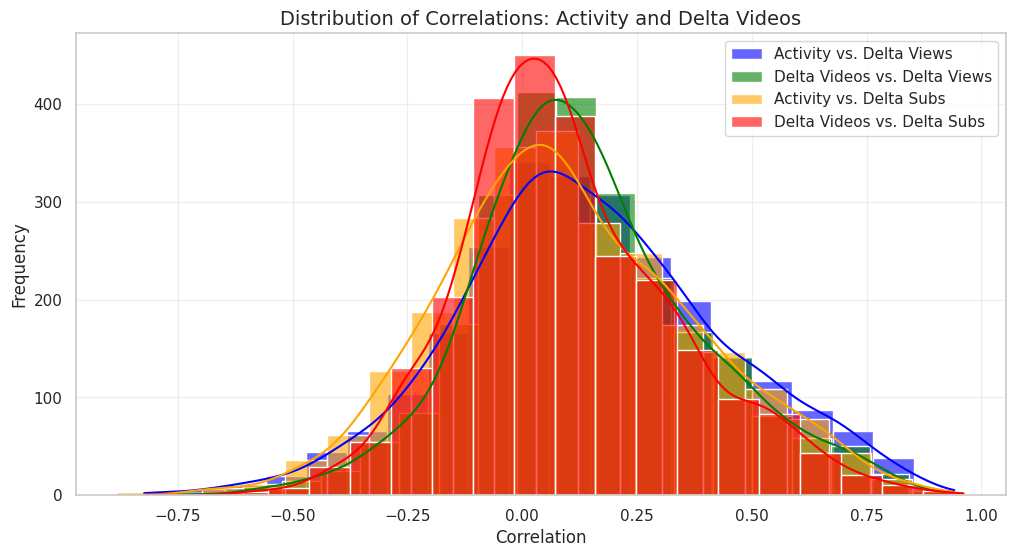

In [ ]:
# Plot histogram for activity vs delta_views/subs and delta_videos vs delta_views/subs
plt.figure(figsize=(12, 6))
sns.histplot(correlations["corr_activity_delta_views"], kde=True, bins=20, color="blue", label="Activity vs. Delta Views", alpha=0.6)
sns.histplot(correlations["corr_delta_videos_delta_views"], kde=True, bins=20, color="green", label="Delta Videos vs. Delta Views", alpha=0.6)

sns.histplot(correlations["corr_activity_delta_subs"], kde=True, bins=20, color="orange", label="Activity vs. Delta Subs", alpha=0.6)
sns.histplot(correlations["corr_delta_videos_delta_subs"], kde=True, bins=20, color="red", label="Delta Videos vs. Delta Subs", alpha=0.6)

# Customize plot
plt.title("Distribution of Correlations: Activity and Delta Videos", fontsize=14)
plt.xlabel("Correlation", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### What is the correlation between delta activity(recent uploads in 15 days) and delta views? (India)

In [ ]:
correlations = merged_data[merged_data['country'] == 'IN'].groupby("channel_id").apply(compute_correlation).reset_index()

# Compute 95% CI for each type of correlation
correlation_columns = ["corr_activity_delta_views", "corr_activity_delta_subs",
                       "corr_delta_videos_delta_views", "corr_delta_videos_delta_subs"]

ci_results = {}
for column in correlation_columns:
    mean, lower_ci, upper_ci = compute_ci(correlations, column)
    ci_results[column] = {"mean": mean, "lower_ci": lower_ci, "upper_ci": upper_ci}

# Convert CI results to a DataFrame for reference
ci_df = pd.DataFrame(ci_results).T.reset_index()
ci_df.columns = ["Correlation Type", "Mean", "Lower CI", "Upper CI"]
print(ci_df)

                Correlation Type      Mean  Lower CI  Upper CI
0      corr_activity_delta_views  0.152546  0.120575  0.184516
1       corr_activity_delta_subs  0.137959  0.107799  0.168120
2  corr_delta_videos_delta_views  0.157180  0.129010  0.185350
3   corr_delta_videos_delta_subs  0.146664  0.119739  0.173589


<ipython-input-42-368dc08cec67>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = merged_data[merged_data['country'] == 'IN'].groupby("channel_id").apply(compute_correlation).reset_index()


<ipython-input-43-7ddb2853f48d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Correlation Type", y="Correlation", data=correlation_melted, palette="Set2")


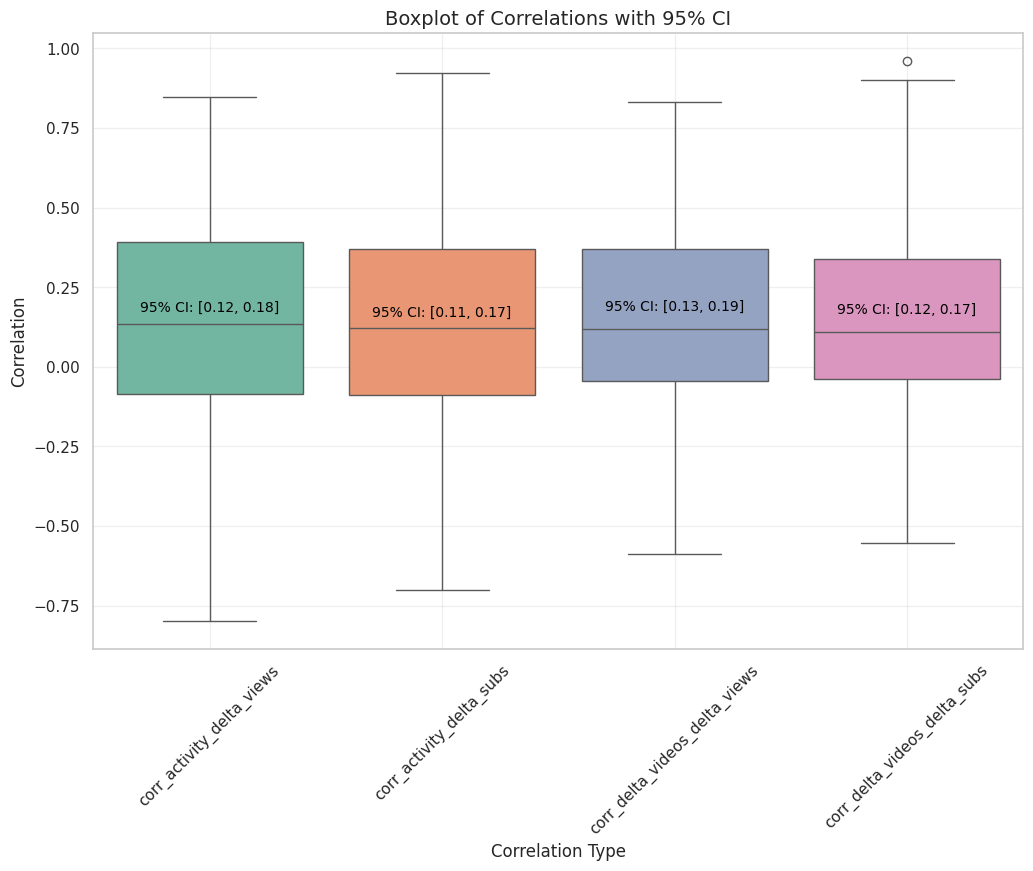

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt correlations for boxplot
correlation_melted = correlations.melt(id_vars=["channel_id"],
                                       value_vars=correlation_columns,
                                       var_name="Correlation Type", value_name="Correlation")

# Plot boxplots with 95% CI annotations
plt.figure(figsize=(12, 8))
sns.boxplot(x="Correlation Type", y="Correlation", data=correlation_melted, palette="Set2")

# Add CI annotations
for i, row in ci_df.iterrows():
    plt.text(
        i, row["Mean"] + 0.02,  # Slightly above the mean
        f"95% CI: [{row['Lower CI']:.2f}, {row['Upper CI']:.2f}]",
        ha="center", fontsize=10, color="black"
    )

# Customize plot
plt.title("Boxplot of Correlations with 95% CI (INDIA)", fontsize=14)
plt.xlabel("Correlation Type", fontsize=12)
plt.ylabel("Correlation", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.show()

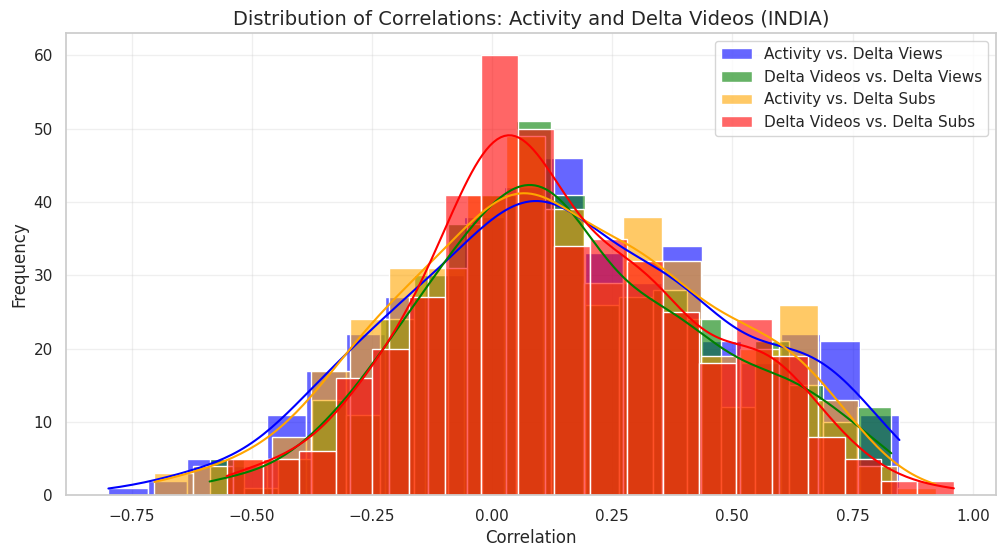

In [ ]:
# Plot histogram for activity vs delta_views/subs and delta_videos vs delta_views/subs
plt.figure(figsize=(12, 6))
sns.histplot(correlations["corr_activity_delta_views"], kde=True, bins=20, color="blue", label="Activity vs. Delta Views", alpha=0.6)
sns.histplot(correlations["corr_delta_videos_delta_views"], kde=True, bins=20, color="green", label="Delta Videos vs. Delta Views", alpha=0.6)

sns.histplot(correlations["corr_activity_delta_subs"], kde=True, bins=20, color="orange", label="Activity vs. Delta Subs", alpha=0.6)
sns.histplot(correlations["corr_delta_videos_delta_subs"], kde=True, bins=20, color="red", label="Delta Videos vs. Delta Subs", alpha=0.6)

# Customize plot
plt.title("Distribution of Correlations: Activity and Delta Videos (INDIA)", fontsize=14)
plt.xlabel("Correlation", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
from statsmodels.formula.api import ols

# Create a regression dataset
regression_data = merged_data[["activity", "delta_subs", "delta_views"]].dropna()

# Fit a regression model for delta_subs
model_subs = ols("delta_subs ~ activity", data=regression_data).fit()

# Fit a regression model for delta_views
model_views = ols("delta_views ~ activity", data=regression_data).fit()

# Summarize results
print(model_subs.summary())
print(model_views.summary())

                            OLS Regression Results                            
Dep. Variable:             delta_subs   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     29.92
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           4.49e-08
Time:                        21:34:53   Log-Likelihood:            -4.0252e+06
No. Observations:              381576   AIC:                         8.050e+06
Df Residuals:                  381574   BIC:                         8.050e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1559.9336     14.976    104.162      0.0

### Other stuff

In [ ]:
# Classify channels based on average activity
merged_data["avg_activity"] = merged_data.groupby("channel_id")["activity"].transform("mean")

def classify_activity_level(activity):
    if activity > 10:
        return "High"
    elif activity > 5:
        return "Medium"
    else:
        return "Low"

merged_data["activity_level"] = merged_data["avg_activity"].apply(classify_activity_level)

# Aggregate growth metrics by activity level
activity_growth = merged_data.groupby("activity_level").agg(
    avg_delta_subs=("delta_subs", "mean"),
    avg_delta_views=("delta_views", "mean")
).reset_index()

# Compare results
print(activity_growth)

  activity_level  avg_delta_subs  avg_delta_views
0           High     2820.895790    618606.756024
1            Low     1288.411557    274174.243433
2         Medium     1849.127550    385282.509989


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# -------------------------------------------
# Example Data Understanding and Setup
# -------------------------------------------
# merged_data columns:
# datetime (weekly), views, delta_views, subs, delta_subs, videos, delta_videos,
# activity (videos published in last 15 days), channel_id, name, country

# stem_videos columns:
# channel_id, upload_date, title, description, stem_tags, subject

# For demonstration, we assume these DataFrames are already loaded:
# merged_data = pd.read_csv("merged_data.csv", parse_dates=['datetime'])
# stem_videos = pd.read_csv("stem_videos.csv", parse_dates=['upload_date'])

# -------------------------------------------
# Segmenting Channels into "Large" vs. "Small"
# -------------------------------------------
# One approach: define a threshold based on median or quartiles of total views or subs.
channel_size_threshold = merged_data['subs'].median()  # you could use 'views' as well
large_channels = merged_data[merged_data['subs'] >= channel_size_threshold]['channel_id'].unique()
small_channels = merged_data[merged_data['subs'] < channel_size_threshold]['channel_id'].unique()

# Filter data
large_channels_data = merged_data[merged_data['channel_id'].isin(large_channels)]
small_channels_data = merged_data[merged_data['channel_id'].isin(small_channels)]

# Aggregate trends over time for large vs. small channels (e.g., median views over time)
large_trend = large_channels_data.groupby('datetime').agg({
    'views': 'median',
    'delta_views': 'median',
    'subs': 'median',
    'delta_subs': 'median',
    'activity': 'median',
    'videos': 'median'
}).reset_index()

small_trend = small_channels_data.groupby('datetime').agg({
    'views': 'median',
    'delta_views': 'median',
    'subs': 'median',
    'delta_subs': 'median',
    'activity': 'median',
    'videos': 'median'
}).reset_index()

# -------------------------------------------
# Visualize Time Series Trends
# -------------------------------------------
# Compare median delta_subs over time between large and small channels
fig = go.Figure()
fig.add_trace(go.Scatter(x=large_trend['datetime'], y=large_trend['delta_subs'],
                         mode='lines', name='Large Channels (Delta Subs)'))
fig.add_trace(go.Scatter(x=small_trend['datetime'], y=small_trend['delta_subs'],
                         mode='lines', name='Small Channels (Delta Subs)'))
fig.update_layout(title="Comparison of Subscriber Growth Over Time",
                  xaxis_title="Time", yaxis_title="Median Delta Subscribers",
                  hovermode='x unified')
fig.show()


In [ ]:
# Select a large channel from channels DataFrame
median_subs = channels[channels['channel_id'].isin(channels_of_interest.channel_id)]['subscribers_cc'].median()  # Assuming subscribers_cc is in channels
channels_of_interest['channel_size'] = channels_of_interest['subscribers_cc'].apply(lambda x: 'Large' if x >= median_subs else 'Small')

<ipython-input-27-d989f79a71b6>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-81-35ada66b9766>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



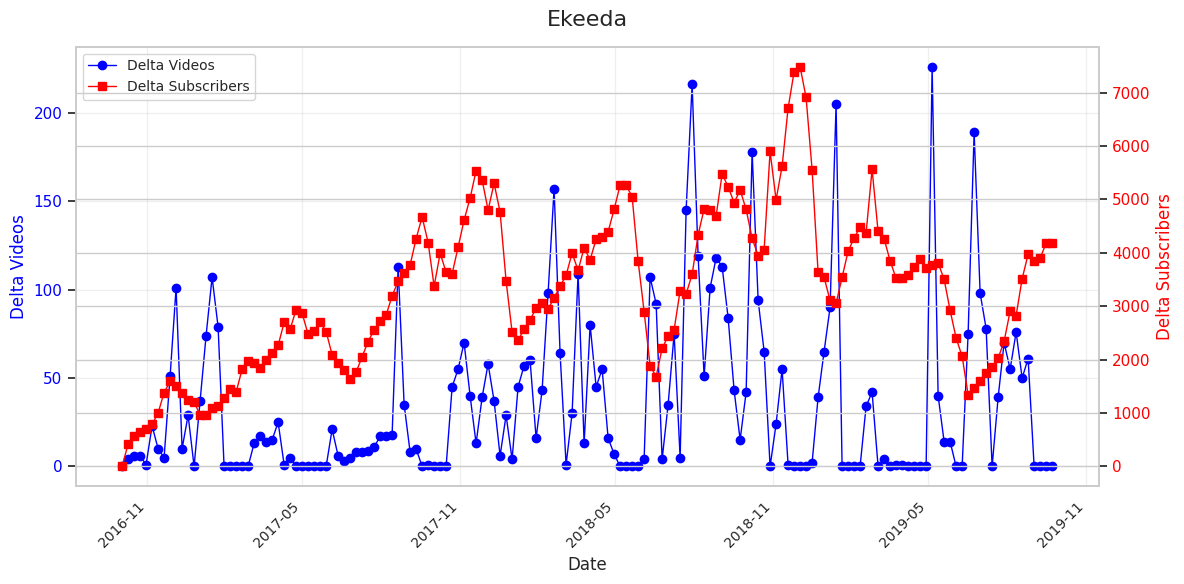

In [81]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_time_series_relationship(channel_name, channel_data):
    """
    Plots the time series relationship between delta_videos and delta_subscribers for a given channel.

    Parameters:
        channel_name (str): The name of the channel.
        channel_data (DataFrame): The time series data for the channel, containing
                                  'datetime', 'delta_videos', and 'delta_subs' columns.

    Returns:
        None
    """
    # Ensure 'datetime' is in datetime format
    channel_data['datetime'] = pd.to_datetime(channel_data['datetime'])

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot delta_videos on the primary y-axis
    ax1.plot(
        channel_data['datetime'], channel_data['delta_videos'],
        label='Delta Videos', color='blue', marker='o', linewidth=1
    )
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Delta Videos', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis for delta_subscribers
    ax2 = ax1.twinx()
    ax2.plot(
        channel_data['datetime'], channel_data['delta_subs'],
        label='Delta Subscribers', color='red', marker='s', linewidth=1
    )
    ax2.set_ylabel('Delta Subscribers', color='red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')

    # Add title
    ax1.set_title(f"{channel_name}", fontsize=16, pad=15)
    ax1.grid(alpha=0.3)

    # Format the x-axis for better readability
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Show year and month
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Tick every 6 months
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=10)  # Rotate xticks

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

    # Add tight layout for proper spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
# Filter data for a specific channel
channel_name = "Ekeeda"
channel_id = "UCltVEZ6GecWntoZ19FvaWhQ"
channel_data_filtered = channel_data[channel_data['channel_id'] == channel_id]

# Plot
plot_time_series_relationship(channel_name, channel_data_filtered)

In [87]:
channel_data = channel_data[channel_data['name_cc'] == 'Webslesson']
channel_data

,channel_id,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,...,growth_rate,date,year,month,week,day,season,is_exam_season,avg_activity,region
299640,UC8Nbgc4vUi27HgBv2ffEiHw,Education,2016-03-14 00:00:00,8.027000e+03,825.000000,374.750000,0.000000,26,0,9,...,0.000000,2016-03-14 00:00:00,2016,3,11,0,Other,False,5.870968,India
299641,UC8Nbgc4vUi27HgBv2ffEiHw,Education,2016-03-21 00:00:00,1.105651e+04,3029.513089,429.413613,54.663613,29,3,8,...,12.729828,2016-03-21 00:00:00,2016,3,12,0,Other,False,5.870968,India
299642,UC8Nbgc4vUi27HgBv2ffEiHw,Education,2016-03-28 01:00:00,1.494489e+04,3888.377536,481.364583,51.950971,33,4,7,...,10.792437,2016-03-28 01:00:00,2016,3,13,0,Other,False,5.870968,India
299643,UC8Nbgc4vUi27HgBv2ffEiHw,Education,2016-04-04 01:00:00,1.996652e+04,5021.625000,542.614583,61.250000,37,4,9,...,11.287938,2016-04-04 01:00:00,2016,4,14,0,Other,False,5.870968,India
299644,UC8Nbgc4vUi27HgBv2ffEiHw,Education,2016-04-11 01:00:00,2.500702e+04,5040.505208,616.703125,74.088542,42,5,10,...,12.013648,2016-04-11 01:00:00,2016,4,15,0,Other,False,5.870968,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299821,UC8Nbgc4vUi27HgBv2ffEiHw,Education,2019-09-02 01:00:00,8.351487e+06,79871.008681,46106.736111,365.293403,516,2,7,...,0.792278,2019-09-02 01:00:00,2019,9,36,0,Other,False,5.870968,India
299822,UC8Nbgc4vUi27HgBv2ffEiHw,Education,2019-09-09 01:00:00,8.430118e+06,78630.533333,46454.402778,347.666667,518,2,5,...,0.748404,2019-09-09 01:00:00,2019,9,37,0,Other,False,5.870968,India
299823,UC8Nbgc4vUi27HgBv2ffEiHw,Education,2019-09-16 01:00:00,8.508803e+06,78685.002778,46802.500000,348.097222,520,2,4,...,0.743758,2019-09-16 01:00:00,2019,9,38,0,Other,False,5.870968,India
299824,UC8Nbgc4vUi27HgBv2ffEiHw,Education,2019-09-23 01:00:00,8.596584e+06,87781.400000,47222.500000,420.000000,523,3,5,...,0.889407,2019-09-23 01:00:00,2019,9,39,0,Other,False,5.870968,India


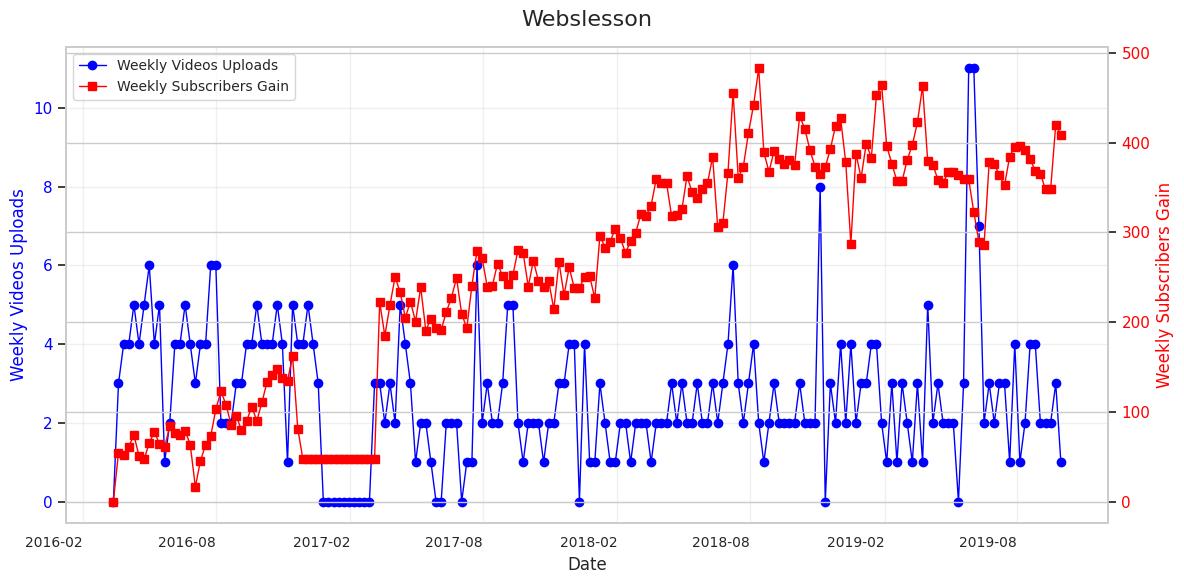

In [90]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_time_series_relationship(channel_name, channel_data):
    """
    Plots the time series relationship between delta_videos and delta_subscribers for a given channel.

    Parameters:
        channel_name (str): The name of the channel.
        channel_data (DataFrame): The time series data for the channel, containing
                                  'datetime', 'delta_videos', and 'delta_subs' columns.

    Returns:
        None
    """
    # Ensure 'datetime' is in datetime format
    channel_data['datetime'] = pd.to_datetime(channel_data['datetime'])

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot delta_videos on the primary y-axis
    ax1.plot(
        channel_data['datetime'], channel_data['delta_videos'],
        label='Weekly Videos Uploads', color='blue', marker='o', linewidth=1
    )
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Weekly Videos Uploads', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis for delta_subscribers
    ax2 = ax1.twinx()
    ax2.plot(
        channel_data['datetime'], channel_data['delta_subs'],
        label='Weekly Subscribers Gain', color='red', marker='s', linewidth=1
    )
    ax2.set_ylabel('Weekly Subscribers Gain', color='red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')

    # Add title
    ax1.set_title(f"{channel_name}", fontsize=16, pad=15)
    ax1.grid(alpha=0.3)

    # Format the x-axis for better readability
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Show year and month
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Tick every 6 months
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0, ha='right', fontsize=10)  # Rotate xticks

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

    # Add tight layout for proper spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
# Filter data for a specific channel
channel_name = "Webslesson"
channel_id = "UC8Nbgc4vUi27HgBv2ffEiHw"
channel_data_filtered = channel_data[channel_data['channel_id'] == channel_id]

# Plot
plot_time_series_relationship(channel_name, channel_data_filtered)

**This channel sometimes uploads more than 100 videos in a week!**

Ekeeda is a education center for teaching STEM content (It contains almost everything in STEM).While there are instances where a spike in uploads is followed by a rise in subscriber growth(e.g., around mid-2017 and mid-2018), this is not always consistent. In some weeks, high upload counts do not correspond to significant subscriber gains, suggesting that quantity alone may not guarantee growth.

While frequent uploads can drive some growth, the lack of consistent alignment suggests that content quality, relevance, and timing also play significant roles.

Channels like this one may aim for mass content production to target a broad audience, relying on volume rather than individual video performance.

In [ ]:
# Pick a Small channel
selected_channel = channels_of_interest[channels_of_interest['channel_size'] == 'Small'].iloc[100]  # Get the first large channel
channel_id = selected_channel['channel_id']
channel_name = selected_channel['name_cc']

# Filter the time series data for this channel from merged_data
channel_data = merged_data[merged_data['channel_id'] == channel_id]

# Call the function to plot
plot_channel_trends(channel_id, channel_name, channel_data)

**This Channel uploaded videos more regularly.**

The general alignment between upload frequency and subscriber growth suggests that regular uploads contribute to steady growth. However, the occasional spikes in delta_subs suggest that individual video performance or external factors have a significant impact.

In [45]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy.stats import t

# Step 1: Classify channels into quadrants based on median
median_subs = channels_of_interest['subscribers_cc'].median()
median_videos = channels_of_interest['videos_cc'].median()

def classify_channel(row):
    if row['subscribers_cc'] >= median_subs and row['videos_cc'] >= median_videos:
        return 'High Subscribers + High Videos'
    elif row['subscribers_cc'] >= median_subs and row['videos_cc'] < median_videos:
        return 'High Subscribers + Low Videos'
    elif row['subscribers_cc'] < median_subs and row['videos_cc'] >= median_videos:
        return 'Low Subscribers + High Videos'
    else:
        return 'Low Subscribers + Low Videos'

channels_of_interest['quadrant'] = channels_of_interest.apply(classify_channel, axis=1)


<ipython-input-45-a2d7d6d10588>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



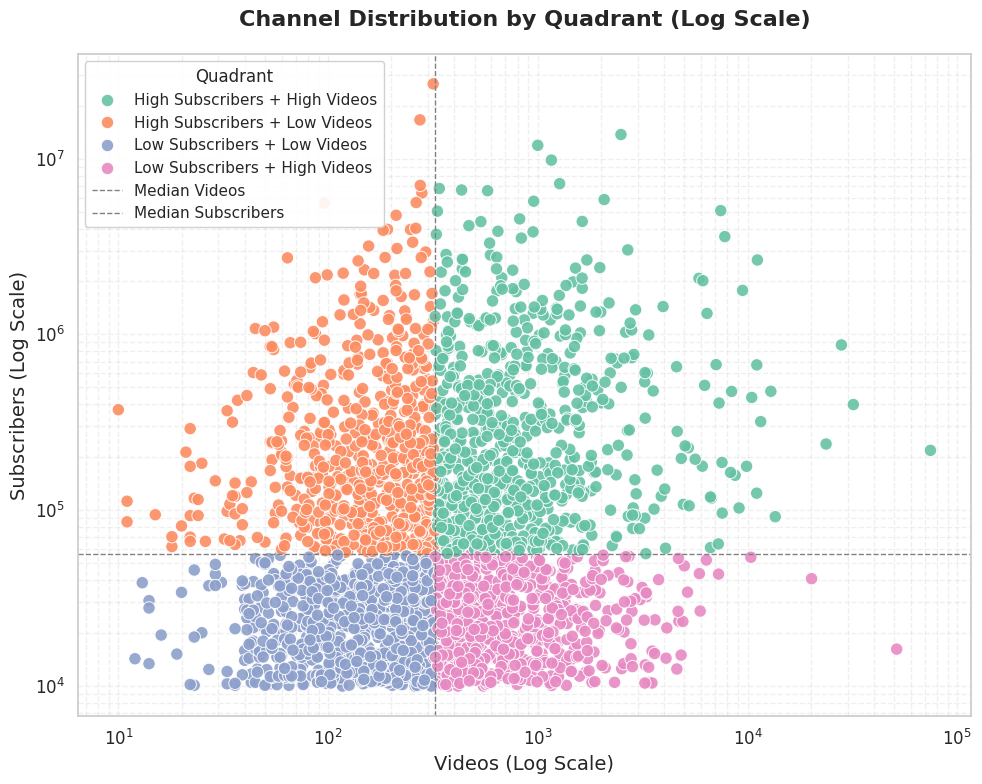

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up figure and style for publication-quality plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 8))

# Scatter plot with log scales
scatter = sns.scatterplot(
    data=channels_of_interest,
    x='videos_cc',
    y='subscribers_cc',
    hue='quadrant',
    palette='Set2',
    s=80,  # Marker size
    alpha=0.9  # Transparency
)

# Set log scale for both axes
scatter.set_xscale('log')
scatter.set_yscale('log')

# Draw dividing lines (median values)
plt.axvline(x=median_videos, color='gray', linestyle='--', linewidth=1, label='Median Videos')
plt.axhline(y=median_subs, color='gray', linestyle='--', linewidth=1, label='Median Subscribers')

# Add labels and title with scientific formatting
plt.title("Channel Distribution by Quadrant (Log Scale)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Videos (Log Scale)", fontsize=14)
plt.ylabel("Subscribers (Log Scale)", fontsize=14)

# Add legend with appropriate formatting
plt.legend(
    title="Quadrant",
    title_fontsize=12,
    fontsize=11,
    loc='upper left',
    frameon=True,
    framealpha=0.9
)

# Add grid with fine transparency
plt.grid(alpha=0.3, which='both', linestyle='--')

# Customize ticks for better scientific presentation
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add tight layout for proper spacing
plt.tight_layout()

# Show plot
plt.show()

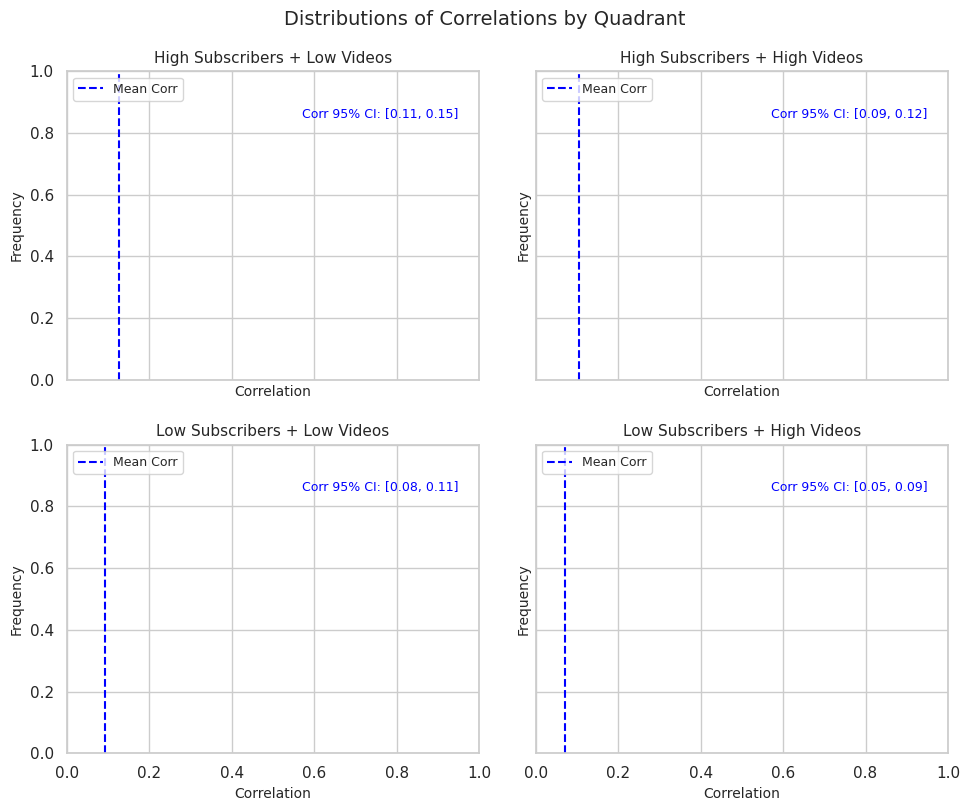

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the quadrant order
quadrant_order = ['High Subscribers + Low Videos', 'High Subscribers + High Videos',
                  'Low Subscribers + Low Videos', 'Low Subscribers + High Videos']

# Step 4: Plot correlation distributions for each quadrant
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)  # Smaller figure size
axes = axes.flatten()  # Flatten axes for easier indexing

for i, quadrant in enumerate(quadrant_order):
    ax = axes[i]
    quadrant_data = correlations_df[correlations_df['quadrant'] == quadrant]

    # Plot histogram of correlation
    sns.histplot(quadrant_data['correlation'], kde=True, bins=15, ax=ax, color="blue", alpha=0.6, label='Correlation')

    # Get confidence intervals
    ci_row = ci_df[ci_df['quadrant'] == quadrant].iloc[0]
    corr_ci_text = f"Corr 95% CI: [{ci_row['lower_corr']:.2f}, {ci_row['upper_corr']:.2f}]"

    # Add vertical line for mean
    ax.axvline(ci_row['mean_corr'], color="blue", linestyle="--", label="Mean Corr")

    # Annotate CI
    ax.text(0.95, 0.85, corr_ci_text, transform=ax.transAxes, ha="right", fontsize=9, color="blue")

    # Title and labels
    ax.set_title(f"{quadrant}", fontsize=11)
    ax.set_xlabel("Correlation", fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.legend(loc='upper left', fontsize=9)  # Move legend to top-left corner

# Adjust layout
plt.tight_layout(pad=1.5)  # Reduce padding between subplots
plt.suptitle("Distributions of Correlations by Quadrant", fontsize=14, y=1.02)
plt.show()

The distributions of the **correlation between Delta Videos and Delta Subscribers**
suggest that quantity alone is not a significant driver of subscriber growth. Other factors, such as video quality, topic relevance, audience engagement, or external promotion, likely play a larger role.
Whether a channel has many or few subscribers, or uploads frequently or infrequently, the relationship between Delta Videos and Delta Subscribers appears to remain consistently weak.

BAD RESULTS QAQ


----

If we only analyze Indian STEM videos and see what strategy they use

In [33]:
# Filter Indian channels
indian_channels = channels_of_interest[channels_of_interest['country'] == 'India']
indian_channel_ids = indian_channels['channel_id']

# Filter the merged_data for Indian channels
indian_channel_data = merged_data[merged_data['channel_id'].isin(indian_channel_ids)]

<ipython-input-34-d27c9c0f2f78>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



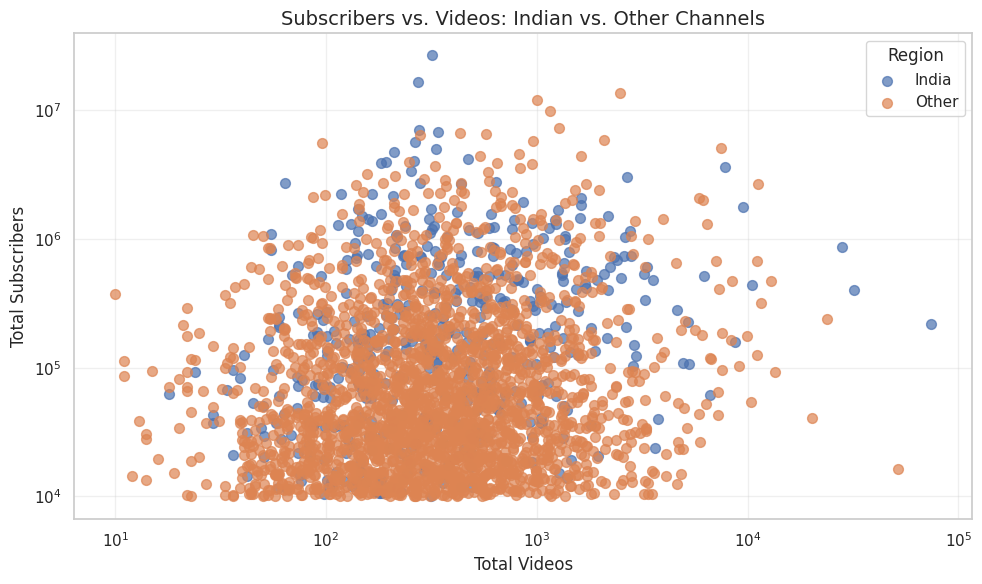

In [34]:
import matplotlib.pyplot as plt

# Add a column to differentiate Indian and non-Indian channels
channels_of_interest['region'] = channels_of_interest['country'].apply(lambda x: 'India' if x == 'IN' else 'Other')

# Plot the scatter plot
plt.figure(figsize=(10, 6))
for region, group_data in channels_of_interest.groupby('region'):
    plt.scatter(
        group_data['videos_cc'],
        group_data['subscribers_cc'],
        label=region,
        alpha=0.7,
        s=50
    )

# Add labels and title
plt.title("Subscribers vs. Videos: Indian vs. Other Channels", fontsize=14)
plt.xlabel("Total Videos", fontsize=12)
plt.ylabel("Total Subscribers", fontsize=12)
plt.xscale('log')  # Log scale for better visualization of wide ranges
plt.yscale('log')
plt.legend(title="Region")
plt.grid(alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

In [43]:
stem_videos

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,title,upload_date,...,name_cc,subscribers_cc,country,is_stem_title,title_matched_keywords,is_stem_tags,tag_matched_tags,tag_matched_keywords,stem_category,processed_title
0,Education,UCzxRv9BtqrM946JmaMLtv_w,2019-11-01 03:57:02.090413,8.0,PAKJpfxeXjc,5768,91.0,"CyberBionic,ITVDN,программирование,курсы прогр...",SQLAlchemy ORM: удобная работа с базами данных...,2019-09-10 00:00:00,...,ITVDN,163699.0,UA,True,python,True,"python, python orm, python sql, python sql alc...",python,programming languages,sqlalchemy orm удобная работа с базами данных ...
1,Education,UCzxRv9BtqrM946JmaMLtv_w,2019-11-01 03:57:08.214188,11.0,6U3vLnEQ3GE,3616,84.0,"PHP,как стать junior php,junior php,junior php...",Как стать PHP разработчиком?,2019-08-07 00:00:00,...,ITVDN,163699.0,UA,True,php,True,"PHP, junior php, junior php developer, junior ...","development, php","biology, programming languages",как стать php разработчиком
2,Education,UCzxRv9BtqrM946JmaMLtv_w,2019-11-01 03:57:10.914306,13.0,MKuckMtKLwo,4649,72.0,"CyberBionic,ITVDN,программирование,курсы прогр...",ASP.NET Core. Лучшие архитектурные практики. Ч...,2019-07-24 00:00:00,...,ITVDN,163699.0,UA,True,asp,True,"ASP.NET Core, asp net, asp net core",asp,computation,aspnet core лучшие архитектурные практики часть
3,Education,UCzxRv9BtqrM946JmaMLtv_w,2019-11-01 03:57:12.586102,0.0,FoGl2_21Erw,718,15.0,"CyberBionic,ITVDN,программирование,курсы прогр...",ASP.NET MVC 5. Углубленный. SignalR 2. Урок 4,2019-07-19 00:00:00,...,ITVDN,163699.0,UA,True,asp,True,"ASP.NET Identity, ASP.NET MVC, ASP.NET MVC 5, ...",asp,computation,aspnet mvc углубленный signalr урок
4,Education,UCzxRv9BtqrM946JmaMLtv_w,2019-11-01 03:57:13.136859,1.0,WWVBpIEPc4Y,633,12.0,"ITVDN,программирование,курсы программирования,...",Обобщения. Kotlin. Урок 9,2019-07-18 00:00:00,...,ITVDN,163699.0,UA,True,kotlin,True,"kotlin, kotlin android, kotlin lessons, kotlin...",kotlin,programming languages,обобщения kotlin урок
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74712,Education,UC-0d3muMfcERwnqn7CEIW-A,2019-11-11 07:56:27.331261,38.0,5cKJ_AbzllQ,838,926.0,"php in hindi,php tutorials,php tutorials in hi...",php in hindi part-4 php errors and organize fi...,2014-05-07 00:00:00,...,hindidevtuts,144547.0,IN,True,"php, root",True,"learn php, learn php in hindi, learning php in...","learning, php","artificial intelligence, programming languages...",php in hindi php errors and organize files on...
74713,Education,UC-0d3muMfcERwnqn7CEIW-A,2019-11-11 07:56:27.909095,67.0,XXDhPKM_xT4,1109,2211.0,"php in hindi,php tutorials,php tutorials in hi...","php tutorials in hindi part 3 variables,commen...",2014-04-29 00:00:00,...,hindidevtuts,144547.0,IN,True,"php, variables",True,"learn php, learn php in hindi, learning php in...","learning, php","artificial intelligence, programming languages",php tutorials in hindi variablescommentssyntax
74714,Education,UC-0d3muMfcERwnqn7CEIW-A,2019-11-11 07:55:37.834092,171.0,WS5ZotHhm2w,1141,4398.0,"php in hindi,php tutorials,php tutorials in hi...",php tutorials in hindi part-2 Installing Apach...,2014-04-17 00:00:00,...,hindidevtuts,144547.0,IN,True,php,True,"learn php, learn php in hindi, learning php in...","learning, php","artificial intelligence, programming languages",php tutorials in hindi installing apachephpmysql
74715,Education,UC-0d3muMfcERwnqn7CEIW-A,2019-11-11 07:55:38.378592,261.0,7ueMK_gwUs8,536,7366.0,"php in hindi,php tutorials,php tutorials in hi...",php tutorials in hindi Part-1 Getting Started,2014-04-15 00:00:00,...,hindidevtuts,144547.0,IN,True,php,True,"learn php, learn php in hindi, learning php in...","learning, php","artificial intelligence, programming languages",php tutorials in hindi getting started


In [39]:
import pandas as pd
from scipy.stats import mannwhitneyu, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

india_data = merged_data[merged_data['country'] == 'IN']['delta_videos']
other_data = merged_data[merged_data['country'] != 'IN']['delta_videos']

print(f"India sample size: {len(india_data)}")
print(f"Other countries sample size: {len(other_data)}")

india_data = india_data.dropna()
other_data = other_data.dropna()

stat, p_value_mwu = mannwhitneyu(india_data, other_data, alternative='greater')
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p_value_mwu}")

t_stat, p_value_t = ttest_ind(india_data, other_data, equal_var=False)
print(f"T-test statistic: {t_stat}, p-value: {p_value_t}")

india_mean = india_data.mean()
other_mean = other_data.mean()
print(f"India mean delta_videos: {india_mean}")
print(f"Other countries mean delta_videos: {other_mean}")

India sample size: 56869
Other countries sample size: 324707
Mann-Whitney U test statistic: 10365951033.0, p-value: 0.0
T-test statistic: 5.518438347445584, p-value: 3.435117546794541e-08
India mean delta_videos: 5.277374316411402
Other countries mean delta_videos: 2.06199743153058


<ipython-input-40-318bd85364e7>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




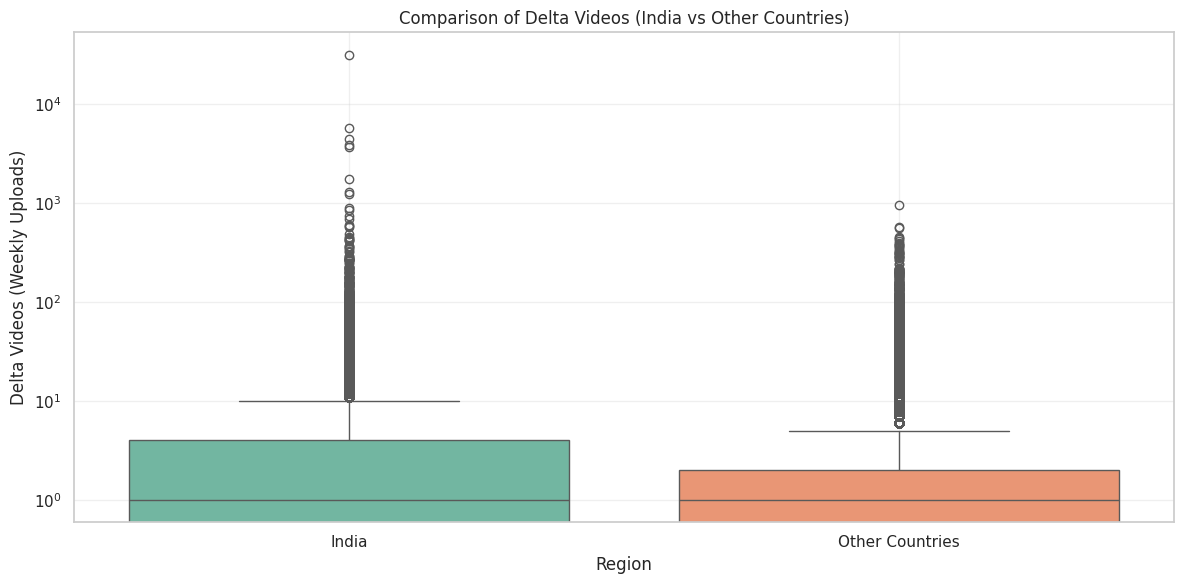

In [40]:
# 添加国家分类
merged_data['region'] = merged_data['country'].apply(lambda x: 'India' if x == 'IN' else 'Other Countries')

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='region', y='delta_videos', palette='Set2')
plt.yscale('log')
plt.title("Comparison of Delta Videos (India vs Other Countries)")
plt.xlabel("Region")
plt.ylabel("Delta Videos (Weekly Uploads)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Step 1: Preprocess titles
def preprocess_title(title):
    import re
    title = title.lower()  # Convert to lowercase
    title = re.sub(r'\b(part|episode|ep|chapter)\b', '', title)  # Remove common series keywords
    title = re.sub(r'\d+', '', title)  # Remove numbers
    title = re.sub(r'[^\w\s]', '', title)  # Remove special characters
    return title.strip()

stem_videos['processed_title'] = stem_videos['title'].apply(preprocess_title)

# Step 2: Measure similarity between titles
def compute_similarity_matrix(titles):
    vectorizer = TfidfVectorizer().fit_transform(titles)
    return cosine_similarity(vectorizer)

# Step 3: Identify series
def identify_series(stem_videos, similarity_threshold=0.8, duration_tolerance=60):
    # Compute similarity matrix
    similarity_matrix = compute_similarity_matrix(stem_videos['processed_title'])

    # Group videos based on similarity and duration
    series_labels = [-1] * len(stem_videos)  # Initialize series labels
    current_label = 0

    for i in range(len(stem_videos)):
        if series_labels[i] == -1:  # Unlabeled video
            series_labels[i] = current_label
            for j in range(len(stem_videos)):
                if i != j and series_labels[j] == -1:
                    # Check similarity and duration tolerance
                    if (
                        similarity_matrix[i, j] >= similarity_threshold and
                        abs(stem_videos.iloc[i]['duration'] - stem_videos.iloc[j]['duration']) <= duration_tolerance
                    ):
                        series_labels[j] = current_label
            current_label += 1

    stem_videos['series_label'] = series_labels
    return stem_videos

# Apply the function
indian_stem_videos = stem_videos[stem_videos['country'] == 'India']
indian_stem_videos = identify_series(indian_stem_videos)

# Step 4: Analyze series
series_summary = indian_stem_videos.groupby('series_label').agg({
    'title': 'count',
    'duration': ['mean', 'std'],
    'tags': lambda x: ', '.join(set(','.join(x).split(',')))  # Combine unique tags
}).reset_index()

# Rename columns for clarity
series_summary.columns = ['series_label', 'video_count', 'mean_duration', 'duration_std', 'tags']
print(series_summary)

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:

# -------------------------------------------
# Calculate Correlations for All Channels
# -------------------------------------------
# Let's consider correlation between activity (upload frequency) and growth metrics
# We'll focus on delta_subs and delta_views correlation with activity
corr_data = merged_data[['channel_id', 'delta_subs', 'delta_views', 'activity']].dropna()
corr_matrix = corr_data[['delta_subs', 'delta_views', 'activity']].corr()
print("Correlation matrix for delta_subs, delta_views, and activity:")
print(corr_matrix)

# We might want to visualize these correlations using plotly as a heatmap
fig = px.imshow(corr_matrix,
                x=['delta_subs', 'delta_views', 'activity'],
                y=['delta_subs', 'delta_views', 'activity'],
                color_continuous_scale='RdBu',
                title="Correlation Heatmap")
fig.show()

In [ ]:
large_corr = large_channels_data[['delta_subs', 'delta_views', 'activity']].corr()
small_corr = small_channels_data[['delta_subs', 'delta_views', 'activity']].corr()

print("Large channels correlation:")
print(large_corr)
print("Small channels correlation:")
print(small_corr)

# Visualize side-by-side comparison
# We'll create two heatmaps and combine them
fig_large = px.imshow(large_corr,
                      x=['delta_subs', 'delta_views', 'activity'],
                      y=['delta_subs', 'delta_views', 'activity'],
                      color_continuous_scale='RdBu',
                      title="Large Channels Correlation")

fig_small = px.imshow(small_corr,
                      x=['delta_subs', 'delta_views', 'activity'],
                      y=['delta_subs', 'delta_views', 'activity'],
                      color_continuous_scale='RdBu',
                      title="Small Channels Correlation")

# Show them individually or you can use subplot to show side by side
fig_large.show()
fig_small.show()

In [ ]:
channel_id_example = merged_data['channel_id'].iloc[0]  # pick a channel for demonstration
channel_data = merged_data[merged_data['channel_id'] == channel_id_example].sort_values('datetime')

# Define lags
lags = [1, 2, 3, 4]
lag_results = []
for lag in lags:
    # Shift delta_subs by 'lag' weeks
    shifted = channel_data['delta_subs'].shift(-lag)
    corr_value = channel_data['activity'].corr(shifted)
    lag_results.append({'lag': lag, 'correlation': corr_value})

lag_results_df = pd.DataFrame(lag_results)
print("Lag correlation results for one example channel:")
print(lag_results_df)

# Visualize lag effect
fig = px.bar(lag_results_df, x='lag', y='correlation',
             title="Correlation Between Activity and Future Delta Subs (Example Channel)")
fig.update_layout(xaxis_title="Lag (weeks ahead)", yaxis_title="Correlation Coefficient")
fig.show()